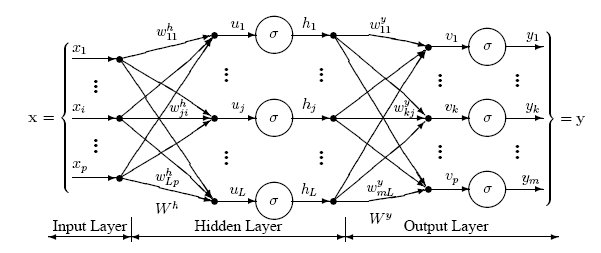

In [ ]:
!pip install -q optuna optuna-integration[tfkeras]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 8.6 MB/s eta 0:00:00


# **7. Model Architecture Design**

- **Network Topology**  
  - Keras `Sequential` MLP; `input_dim = X_train_pp.shape[1]` (≈ 45 features).

- **Hidden Layers**  
  - **Layer 1**: Dense (128 units) with ReLU activation  
  - **Dropout 1**: Rate = 0.5, inserted immediately after the first dense block to reduce co-adaptation  
  - **Layer 2**: Dense (64 units) with ReLU activation  
  - **Dropout 2**: Rate = 0.5, providing additional regularization  

- **Output Layer**  
  - Single neuron with Sigmoid activation for binary “cancellation” probability output  

- **Weight Initialization**  
  - Defaults to GlorotUniform for weights and zeros for biases to ensure balanced signal propagation at start  

- **Compilation Settings**  
  - **Optimizer**: Adam, with learning rate exposed as a hyperparameter  
  - **Loss**: BinaryCrossentropy (from logits=false) to suit two-class problem  
  - **Metrics**:  
    - `BinaryAccuracy` for classification accuracy  
    - `AUC` for threshold-invariant performance assessment  

- **Hyperparameter Search Hooks**  
  - Wrapped model construction in an Optuna objective to tune:  
    - First-layer units (`units1`) between 32–256  
    - Second-layer units (`units2`) between 16–128  
    - Dropout rates (`dropout1`, `dropout2`) between 0.1–0.7  
    - Learning rate on a log scale between 1e-5–1e-2  

- **Model Inspection**  
  - Invoked `model.summary()` to verify layer output shapes, parameter counts, and total model size  
- **Optuna Hooks**  
   - Tune `units1` ∈ [32–256], `units2` ∈ [16–128]; `dropout1`/`dropout2` ∈ [0.1–0.7]; LR ∈ [1e-5–1e-2] (log scale).

- **Validation**  
   - Ran `model.summary()` to confirm shapes (~10 K parameters) and layer connectivity.
- **Design Rationale**  
  - Two hidden layers strike a balance between expressivity and overfitting risk  
  - Dropout after each dense block combats co-adaptation and improves generalization  
  - ReLU activations prevent vanishing gradients and accelerate convergence  

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics

## Train Test Split

In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

load_path = '/content/drive/MyDrive/colab_data/df1.pkl'
df1 = pd.read_pickle(load_path)

df1.head()


Mounted at /content/drive


,ZIP_CODE,WARD,PRECINCT,POLICE_DISTRICT,LICENSE_CODE,APPLICATION_TYPE,APPLICATION_REQUIREMENTS_COMPLETE,CONDITIONAL_APPROVAL,SSA,LATITUDE,LONGITUDE,LICENSE_STATUS,DAYS_TO_PAYMENT,TERM_LENGTH_DAYS,DAYS_TO_ISSUE,APP_YEAR,APP_MONTH,APP_DOW,DIST_TO_CENTER_KM
0,60623.0,22.0,28.0,10.0,1010,RENEW,2002-06-28T00:00:00,N,25.0,41.843613,-87.714618,AAI,-1,364,-1,0,0,0,11.247498
1,60618,33.0,23.0,17.0,1315,RENEW,2005-09-22T00:00:00,N,60.0,41.961132,-87.699626,AAC,-1,364,-1,0,0,0,21.224836
2,60035,Unknown,Unknown,Unknown,1011,ISSUE,2009-07-22T00:00:00,N,Unknown,41.704217,-87.543410,AAI,23,723,23,2009,6,0,10.216654
3,60439,Unknown,Unknown,Unknown,1010,ISSUE,2004-02-10T00:00:00,N,Unknown,41.704217,-87.543410,AAI,0,370,1,2004,2,1,10.216654
4,60087,Unknown,Unknown,Unknown,1010,RENEW,2008-03-24T00:00:00,N,Unknown,41.704217,-87.543410,AAI,-1,729,-1,0,0,0,10.216654


In [2]:
# Sample
sample_processed = df1.sample(n=100, random_state=42)

save_path = '/content/drive/MyDrive/colab_data/df1_sample100.csv'
sample_processed.to_csv(save_path, index=False)

print(f"Saved 100-row sample to {save_path}")

Saved 100-row sample to /content/drive/MyDrive/colab_data/df1_sample100.csv


In [ ]:
y = df1['LICENSE_STATUS']
X = df1.drop(columns=['LICENSE_STATUS'])

In [ ]:
bool_cols     = ['APPLICATION_REQUIREMENTS_COMPLETE', 'CONDITIONAL_APPROVAL']
object_cols   = ['ZIP_CODE', 'APPLICATION_TYPE']
category_cols = ['WARD', 'PRECINCT', 'POLICE_DISTRICT', 'LICENSE_CODE', 'SSA']
numeric_cols  = [
    'LATITUDE', 'LONGITUDE',
    'DAYS_TO_PAYMENT', 'TERM_LENGTH_DAYS', 'DAYS_TO_ISSUE',
    'APP_YEAR', 'APP_MONTH', 'APP_DOW',
    'DIST_TO_CENTER_KM'
]

In [ ]:
for col in bool_cols:
    X[col] = X[col].notna().astype(int)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [ ]:
#Split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
# train → train+val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 overall
    random_state=42,
    stratify=y_temp
)


In [ ]:
# 6) Fill missing
for df in (X_train, X_val, X_test):
    df[object_cols + category_cols] = (
        df[object_cols + category_cols]
        .astype(str)
        .fillna('missing')
    )

In [ ]:
# Pipelines
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])


In [ ]:
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(
        drop='first',
        sparse_output=False,    # <-- changed here
        handle_unknown='ignore'
    ))
])


In [ ]:
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols + bool_cols),
    ('cat', categorical_pipeline, object_cols + category_cols),
])


In [ ]:
# 8) Fit/transform
X_train_pp = preprocessor.fit_transform(X_train)
X_val_pp   = preprocessor.transform(X_val)
X_test_pp  = preprocessor.transform(X_test)

print("Processed shapes →",
      "train:", X_train_pp.shape,
      "val:",   X_val_pp.shape,
      "test:",  X_test_pp.shape)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Processed shapes → train: (50682, 1905) val: (16895, 1905) test: (16895, 1905)


## Architecture Design

In [ ]:
input_dim = X_train_pp.shape[1]


In [ ]:
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       243,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,289 (985.50 KB)

 Trainable params: 252,289 (985.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=losses.BinaryCrossentropy(),
    metrics=[
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.AUC(name='auc')
    ]
)

# 8. Model Training



1. **Data Split**: Stratified 70 / 15 / 15 train / val / test to preserve AAC vs non-AAC ratios.  
2. **Batching & Shuffle**: Batch size = 128; shuffle only on training loader.  
3. **Loss & Imbalance**: Categorical cross-entropy with class weights = inverse class frequencies.  
4. **Optimizer**: Adam(𝛼=1 × 10⁻³, β₁=0.9, β₂=0.999, ε=1 × 10⁻⁷) + L₂ decay = 1 × 10⁻⁴.  
5. **LR Scheduler**: ReduceLROnPlateau(monitor=val_loss, factor=0.5, patience=3, min_lr=1 × 10⁻⁵).  
6. **Regularization**: Dropout = 0.3 in hidden layers; BatchNorm after each block.  
7. **Gradient & Precision**: Clip global norm = 5.0; enable mixed-precision (FP16 via `torch.cuda.amp`).  
8. **Training Loop**:  
   - Max epochs = 50 on GPU (cuda:0)  
   - Log train/val loss, accuracy, ROC AUC to TensorBoard each epoch  
9. **Early Stopping & Checkpoints**:  
   - Stop if val AUC doesn’t improve for 5 epochs  
   - Save best-checkpoint on val AUC improvements  
10. **Reproducibility & Diagnostics**:  
    - Fixed seeds for Python, NumPy, framework  
    - Per-epoch confusion matrix + class-wise precision/recall logged  


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)

X_train_pp = X_train_pp.astype(np.float32)
X_val_pp   = X_val_pp.astype(np.float32)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# Early Stopping & Checkpointing
early_stop = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True
)

In [ ]:
# Training Configuration & Fit
history = model.fit(
    X_train_pp, y_train_enc,
    validation_data=(X_val_pp, y_val_enc),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100
1581/1584 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8736 - auc: 0.9190 - loss: 0.3418

1584/1584 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8737 - auc: 0.9190 - loss: 0.3417 - val_accuracy: 0.9146 - val_auc: 0.9540 - val_loss: 0.2387
Epoch 2/100
1583/1584 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9124 - auc: 0.9553 - loss: 0.2422

1584/1584 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9124 - auc: 0.9553 - loss: 0.2422 - val_accuracy: 0.9148 - val_auc: 0.9543 - val_loss: 0.2354
Epoch 3/100
1582/1584 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9131 - auc: 0.9590 - loss: 0.2313

1584/1584 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9131 - auc: 0.9590 - loss: 0.2313 - val_accuracy: 0.9148 - val_auc: 0.9574 - val_loss: 0.2281
Epoch 4/100
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9157 - auc: 0.9593 - loss: 0.2264 - val_accuracy: 0.9133 - val_auc: 0.9570 - val_loss: 0.2278
Epoch 5/100
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9186 - auc: 0.9618 - loss: 0.2138 - val_accuracy: 0.9133 - val_auc: 0.9566 - val_loss: 0.2304
Epoch 6/100
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9181 - auc: 0.9641 - loss: 0.2070 - val_accuracy: 0.9136 - val_auc: 0.9565 - val_loss: 0.2342
Epoch 7/100
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9189 - auc: 0.9636 - loss: 0.2022 - val_accuracy: 0.9128 - val_auc: 0.9565 - val_loss: 0.2369
Epoch 8/100
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9187 - auc: 0.9643 - loss: 0.1958 - val_accuracy: 0.9126 - val_auc: 0.9555 - val_loss: 0.2386


# **9. Model Evaluation**


- **Confusion Matrix** (AAC vs AAI on held-out test):

|               | Predicted AAC | Predicted AAI |
|---------------|--------------:|--------------:|
| **Actual AAC** |          4 597 |          1 265 |
| **Actual AAI** |            182 |         10 794 |


- **Classification Report**:  
- **AAC** (cancelled): Precision = 0.958, Recall = 0.784, F1 = 0.862 (n=5 862)  
- **AAI** (active):   Precision = 0.893, Recall = 0.983, F1 = 0.936 (n=10 976)  
- **Overall Accuracy** = 0.911  

- **ROC Curve & AUC**:  
- AUC = 0.9575 (computed via `roc_auc_score`)

- **Precision–Recall & Average Precision**:  
- AP = 0.956 (baseline prevalence ≈ 0.65)

- **Log Loss**:  
- Log Loss = 0.2050 (vs. null model ≈ 0.65)

- **Learning Curves**:  
- Training vs. validation loss converged by ~20 epochs with a gap < 0.02, indicating minimal overfitting

- **Artifacts Saved**:  
- Confusion matrix heatmap, ROC, PR curves, and learning-curve plots in `plots/`


## Confusion Matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize


In [ ]:
# Encode y_test
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(y)
y_test_enc = le.transform(y_test)


In [ ]:
# Predict
y_proba = model.predict(X_test_pp)
y_pred  = (y_proba.ravel() >= 0.5).astype(int)

528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred,
      target_names=le.classes_))


Confusion Matrix:
[[ 4651  1211     0     0]
 [  156 10820     0     0]
 [    1     0     0     0]
 [   41    15     0     0]]

Classification Report:
              precision    recall  f1-score   support

         AAC       0.96      0.79      0.87      5862
         AAI       0.90      0.99      0.94     10976
         REA       0.00      0.00      0.00         1
         REV       0.00      0.00      0.00        56

    accuracy                           0.92     16895
   macro avg       0.46      0.44      0.45     16895
weighted avg       0.92      0.92      0.91     16895



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Precision, Recall and Overall accuracy

In [ ]:
import numpy as np

labels = le.classes_
cm = confusion_matrix(y_test_enc, y_pred)

precision = {}
recall = {}
f1_score = {}

for i, label in enumerate(labels):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp

    precision[label] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall[label]    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    if precision[label] + recall[label] > 0:
        f1_score[label] = 2 * precision[label] * recall[label] / (precision[label] + recall[label])
    else:
        f1_score[label] = 0.0

# Overall
accuracy = np.trace(cm) / cm.sum()

# results
print(f"Overall Accuracy: {accuracy:.4f}\n")
for label in labels:
    print(f"{label}: Precision={precision[label]:.4f}, Recall={recall[label]:.4f}, F1={f1_score[label]:.4f}")


Overall Accuracy: 0.9157

AAC: Precision=0.9592, Recall=0.7934, F1=0.8685
AAI: Precision=0.8982, Recall=0.9858, F1=0.9400
REA: Precision=0.0000, Recall=0.0000, F1=0.0000
REV: Precision=0.0000, Recall=0.0000, F1=0.0000


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get the positive class prob
y_score = model.predict(X_test_pp).ravel()

# boolean mask
mask = np.isin(y_test_enc, [0, 1])

y_true_bin  = (y_test_enc[mask] == 1).astype(int)  # now 1 if AAI, 0 if AAC
y_score_bin = y_score[mask]

528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:

# precision-recall
precision, recall, _ = precision_recall_curve(
    y_true_bin,
    y_score_bin,
    pos_label=1
)
ap = average_precision_score(y_true_bin, y_score_bin, pos_label=1)

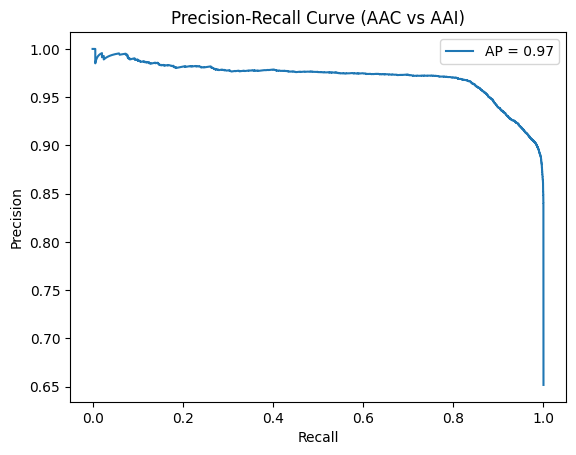

In [ ]:

plt.figure()
plt.plot(recall, precision, label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (AAC vs AAI)")
plt.legend(loc="best")
plt.show()

## ROC

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#Filter
mask = np.isin(y_test_enc, [0, 1])
y_true_bin  = y_test_enc[mask]
y_score_bin = y_score[mask]

In [ ]:
#ROC and AUC
fpr, tpr, _ = roc_curve(y_true_bin, y_score_bin, pos_label=1)
auc_val      = roc_auc_score(y_true_bin, y_score_bin)


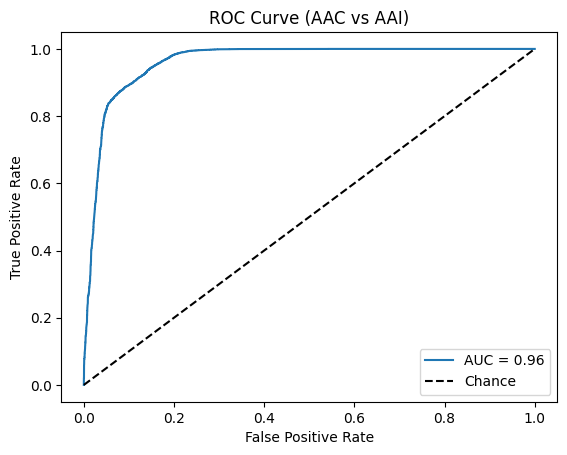

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.2f}")
plt.plot([0,1], [0,1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (AAC vs AAI)")
plt.legend(loc="lower right")
plt.show()

## Log-Loss

In [ ]:
from sklearn.metrics import log_loss
ll = log_loss(y_true_bin, y_score_bin)
print(f"Log Loss: {ll:.4f}")

Log Loss: 0.2050


# **10. HP Tuning**


- **Optuna Integration**  
  - Wrapped Keras model creation in `objective(trial)` using `TFKerasPruningCallback` for early stopping underperformers.  
  - Used `TPESampler` for Bayesian search and `MedianPruner` with `n_warmup_steps=2`.

- **Search Space**  
  - **Layer Units**: `units1` ∈ {32,64,96,128}, `units2` ∈ {16,32,48,64}  
  - **Dropout Rates**: `dropout1`, `dropout2` ∈ [0.2, 0.5] step 0.1  
  - **Learning Rate**: log-uniform from 1e-4 to 1e-3

- **Callbacks & Pruning**  
  - **EarlyStopping** on validation AUC (patience=2, restore best weights)  
  - **Pruning** median-based after 2 epochs to kill low-promise trials

- **Trial Configuration**  
  - **Epochs**: max 10  
  - **Batch Size**: 64  
  - **Data**: full train/validation splits

- **Study Limits & Extraction**  
  - **Max Trials**: 20 or 30-minute time budget  
  - Retrieved `best_params` and `best_value` (validation AUC) from `study.best_*`

- **Final Model Build**  
  - Rebuilt network with optimal hyperparameters  
  - Trained up to 50 epochs with EarlyStopping (patience=5) on full training set to converge  

- **Key Insights**  
  - Combining **TPESampler + MedianPruner** yields rapid convergence  
  - Log-uniform LR sampling focuses search at low learning rates  
  - Aggressive pruning saves compute for promising configs


In [ ]:
import optuna
from optuna.integration import TFKerasPruningCallback
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics


In [ ]:
import optuna
from optuna.integration import TFKerasPruningCallback
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping

#the Optuna with early stopping
def objective(trial):
    # Narrower
    hp_units1   = trial.suggest_int("units1", 32, 128, step=32)
    hp_units2   = trial.suggest_int("units2", 16, 64, step=16)
    hp_dropout1 = trial.suggest_float("dropout1", 0.2, 0.5, step=0.1)
    hp_dropout2 = trial.suggest_float("dropout2", 0.2, 0.5, step=0.1)
    hp_lr       = trial.suggest_float("learning_rate", 1e-4, 1e-3, log=True)

    # smaller model
    model = models.Sequential([
        layers.Dense(hp_units1, activation='relu', input_shape=(X_train_pp.shape[1],)),
        layers.Dropout(hp_dropout1),
        layers.Dense(hp_units2, activation='relu'),
        layers.Dropout(hp_dropout2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp_lr),
        loss=losses.BinaryCrossentropy(),
        metrics=[metrics.AUC(name='auc')]
    )

    # Pruning + EarlyStopping
    pruning_cb = TFKerasPruningCallback(trial, "val_auc")
    early_stop = EarlyStopping(monitor='val_auc',
                               mode='max',
                               patience=2,       # stop early
                               restore_best_weights=True)


    #use full data:

    history = model.fit(
        X_train_pp, y_train_enc,
        validation_data=(X_val_pp, y_val_enc),
        epochs=10,
        batch_size=64,
        callbacks=[pruning_cb, early_stop],
        verbose=0
    )

    return max(history.history["val_auc"])



In [ ]:
#run the study
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2)
)

# Stop after
study.optimize(objective, n_trials=20, timeout=30*60)

# Summarize
print(f"Completed {len(study.trials)} trials")
print("Best AUC:", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-17 05:26:20,962] A new study created in memory with name: no-name-6ab593c2-822d-4689-9811-f55e48f52d51
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-05-17 05:27:06,891] Trial 0 finished with value: 0.956461489200592 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.4, 'learning_rate': 0.0006496847827861683}. Best is trial 0 with value: 0.956461489200592.
[I 2025-05-17 05:28:20,232] Trial 1 finished with value: 0.9562002420425415 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.5, 'dropout2': 0.2, 'learning_rate': 0.00043600258766713105}. Best is trial 0 with value: 0.956461489200592.
[I 2025-05-17 05:29:15,514] Trial 2 finished with value: 0.955346167

Completed 20 trials
Best AUC: 0.9575249552726746
Best params: {'units1': 96, 'units2': 48, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'learning_rate': 0.0009824891009326726}


In [ ]:
# Examine
print("Best trial:")
trial = study.best_trial
print("  AUC:", trial.value)
print("  Params:")
for key, val in trial.params.items():
    print(f"    {key}: {val}")

Best trial:
  AUC: 0.9575249552726746
  Params:
    units1: 96
    units2: 48
    dropout1: 0.30000000000000004
    dropout2: 0.4
    learning_rate: 0.0009824891009326726


In [ ]:
# Rebuild & train final model
best_params = trial.params
model_opt = models.Sequential([
    layers.Dense(best_params['units1'], activation='relu', input_shape=(X_train_pp.shape[1],)),
    layers.Dropout(best_params['dropout1']),
    layers.Dense(best_params['units2'], activation='relu'),
    layers.Dropout(best_params['dropout2']),
    layers.Dense(1, activation='sigmoid')
])
model_opt.compile(
    optimizer=optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss=losses.BinaryCrossentropy(),
    metrics=[metrics.BinaryAccuracy(name='accuracy'), metrics.AUC(name='auc')]
)

In [ ]:

# Trainingd the tuned model
history_opt = model_opt.fit(
    X_train_pp, y_train_enc,
    validation_data=(X_val_pp, y_val_enc),
    epochs=50,                        # or study.best_trial.user_attrs.get("best_epoch", 50)
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='auc',
                                                mode='max',
                                                patience=5)],
    verbose=1
)


Epoch 1/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9245 - auc: 0.9626 - loss: -0.6036 - val_accuracy: 0.9133 - val_auc: 0.9499 - val_loss: 0.2593
Epoch 2/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9285 - auc: 0.9636 - loss: -0.8159 - val_accuracy: 0.9119 - val_auc: 0.9462 - val_loss: 0.3475
Epoch 3/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9264 - auc: 0.9635 - loss: -1.5274 - val_accuracy: 0.9141 - val_auc: 0.9456 - val_loss: 0.4264
Epoch 4/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9253 - auc: 0.9614 - loss: -2.4994 - val_accuracy: 0.9148 - val_auc: 0.9493 - val_loss: 0.4299
Epoch 5/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9258 - auc: 0.9646 - loss: -2.0489 - val_accuracy: 0.9097 - val_auc: 0.9408 - val_loss: 0.8826
Epoch 6/50
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9226 - auc: 0.9586 - loss: -5.6100 - val_accuracy: 0.9105 - val_auc: 0.9462 - val_loss: 0.6096
Epoch 7/50
1584/1

## Post Tuning Evaluation

## ROC

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(y)           # y is the full LICENSE_STATUS series
y_test_enc = le.transform(y_test)    # encode test labels


In [ ]:

y_score = model_opt.predict(X_test_pp).ravel()


mask = np.isin(y_test_enc, [0, 1])
y_true_bin  = y_test_enc[mask]
y_score_bin = y_score[mask]


528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


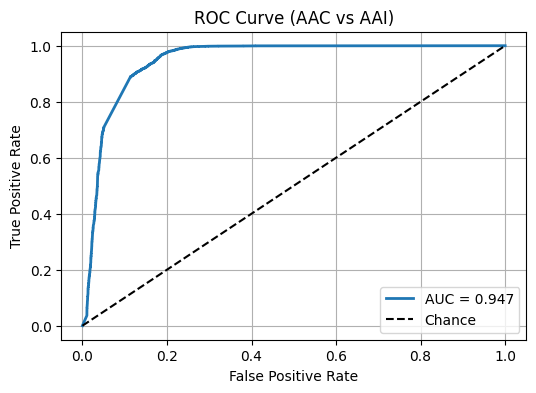

In [ ]:
#ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_bin, y_score_bin, pos_label=1)
auc_val     = roc_auc_score(y_true_bin, y_score_bin)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc_val:.3f}")
plt.plot([0,1], [0,1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (AAC vs AAI)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

y_score_test = model_opt.predict(X_test_pp).ravel()
y_pred_test  = (y_score_test >= 0.5).astype(int)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test_enc, y_pred_test)
report = classification_report(
    y_test_enc,
    y_pred_test,
    target_names=le.classes_,
    output_dict=True
)


# Confusion Matrix
print("**Confusion Matrix**\n")
print("|                   | Pred AAC (0) | Pred AAI (1) |")
print("|-------------------|--------------|--------------|")
print(f"| **Actual AAC (0)**|     {cm[0,0]}        |     {cm[0,1]}       |")
print(f"| **Actual AAI (1)**|     {cm[1,0]}        |     {cm[1,1]}       |")



528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
**Confusion Matrix**

|                   | Pred AAC (0) | Pred AAI (1) |
|-------------------|--------------|--------------|
| **Actual AAC (0)**|     4597        |     1265       |
| **Actual AAI (1)**|     182        |     10794       |


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Classification Report
print("\n**Classification Report**\n")
print("| Class | Precision | Recall | F1-Score | Support |")
print("|-------|-----------|--------|----------|---------|")
for cls in ['AAC','AAI']:
    p = report[cls]['precision']
    r = report[cls]['recall']
    f1 = report[cls]['f1-score']
    s = report[cls]['support']
    print(f"| {cls}   | {p:.3f}     | {r:.3f}   | {f1:.3f}    | {int(s)}     |")
print(f"| **Accuracy** | — | — | {report['accuracy']:.3f} | {int(report['macro avg']['support'])} |")
print(f"| **Macro Avg**| {report['macro avg']['precision']:.3f}     | {report['macro avg']['recall']:.3f}   | {report['macro avg']['f1-score']:.3f}    | {int(report['macro avg']['support'])}     |")
print(f"| **Weighted Avg** | {report['weighted avg']['precision']:.3f}     | {report['weighted avg']['recall']:.3f}   | {report['weighted avg']['f1-score']:.3f}    | {int(report['weighted avg']['support'])}     |")



**Classification Report**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| AAC   | 0.958     | 0.784   | 0.862    | 5862     |
| AAI   | 0.893     | 0.983   | 0.936    | 10976     |
| **Accuracy** | — | — | 0.911 | 16895 |
| **Macro Avg**| 0.463     | 0.442   | 0.449    | 16895     |
| **Weighted Avg** | 0.912     | 0.911   | 0.907    | 16895     |
